<a href="https://colab.research.google.com/github/velez0696/SebastianRestrepo/blob/main/02_Modelos_Weather_Time.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Fuente: Kaggle - https://www.kaggle.com/datasets/arashnic/max-planck-weather-dataset

Este set de datos contiene 14 variables climaticas como temperatura, humedad relativa, presión, entre otras. Estas fueron recolectadas a intervalos de 10 minutos entre los años 2009 y 2017. 

Como objetivo del proyecto a desarrollar se propone un análisis de series de tiempo a través de redes neuronales implementando en estas un algoritmo de aprendizaje evolutivo para el cálculo de los pesos de la red propuesta.

En primer lugar se realiza la carag del Dataset en cuestión y un análisis general de los datos, sus distribuciones, correlaciones y otros datos utilizando la librería pandas_profiling.



# 1. Carga de datos y EDA del dataset

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import tensorflow as tf
import IPython
import IPython.display
from statsmodels.tsa.seasonal import seasonal_decompose

In [6]:
url = 'https://raw.githubusercontent.com/velez0696/SebastianRestrepo/main/max_planck_weather_ts.csv'
df_raw = pd.read_csv(url, index_col=0)
print(df_raw.info())

<class 'pandas.core.frame.DataFrame'>
Index: 420551 entries, 01.01.2009 00:10:00 to 01.01.2017 00:00:00
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   p (mbar)         420551 non-null  float64
 1   T (degC)         420551 non-null  float64
 2   Tpot (K)         420551 non-null  float64
 3   Tdew (degC)      420551 non-null  float64
 4   rh (%)           420551 non-null  float64
 5   VPmax (mbar)     420551 non-null  float64
 6   VPact (mbar)     420551 non-null  float64
 7   VPdef (mbar)     420551 non-null  float64
 8   sh (g/kg)        420551 non-null  float64
 9   H2OC (mmol/mol)  420551 non-null  float64
 10  rho (g/m**3)     420551 non-null  float64
 11  wv (m/s)         420551 non-null  float64
 12  max. wv (m/s)    420551 non-null  float64
 13  wd (deg)         420551 non-null  float64
dtypes: float64(14)
memory usage: 48.1+ MB
None


# 2. Selección de variables a considerar y  resamplig del dataset

Se proponen, para las variables a incluir en el análisis, seleccionar aquellas que tengan un elevado impacto en la predicción climática y con comportamientos distintos entre si; con esto podremos evaluar la capacidad de los modelos de predecir en las diferentes distribuciones. LAs variables seleccionadas para el análisis son las siguientes:

*   T (degC)
*   p (mbar)
*   rho (g/m**3)

Estas serán descritas y graficadas a continuación

Además se genera una definición temporal de dechas de inicio y fin, esto con el fin de realizar validaciones y pruebas antes de desplegar el algoritmo en todo el dataset

In [8]:
df_evo = df_raw.copy()
print(df_evo.columns)
df_evo = df_evo.drop(columns = ['Tpot (K)', 'Tdew (degC)', 'rh (%)',
       'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
       'H2OC (mmol/mol)', 'wv (m/s)', 'max. wv (m/s)',
       'wd (deg)'])
df_evo.reset_index(inplace=True)
print(df_evo.columns)
print(df_evo.head(5))

Index(['p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)', 'rh (%)',
       'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
       'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)',
       'wd (deg)'],
      dtype='object')
Index(['Date Time', 'p (mbar)', 'T (degC)', 'rho (g/m**3)'], dtype='object')
             Date Time  p (mbar)  T (degC)  rho (g/m**3)
0  01.01.2009 00:10:00    996.52     -8.02       1307.75
1  01.01.2009 00:20:00    996.57     -8.41       1309.80
2  01.01.2009 00:30:00    996.53     -8.51       1310.24
3  01.01.2009 00:40:00    996.51     -8.31       1309.19
4  01.01.2009 00:50:00    996.51     -8.27       1309.00


In [9]:
df_evo['Date Time'] = pd.to_datetime(df_evo['Date Time'])
df_evo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420551 entries, 0 to 420550
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Date Time     420551 non-null  datetime64[ns]
 1   p (mbar)      420551 non-null  float64       
 2   T (degC)      420551 non-null  float64       
 3   rho (g/m**3)  420551 non-null  float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 12.8 MB


A continuación se grafican las columnas seleccionadas

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f7970c9c310>,
      dtype=object)

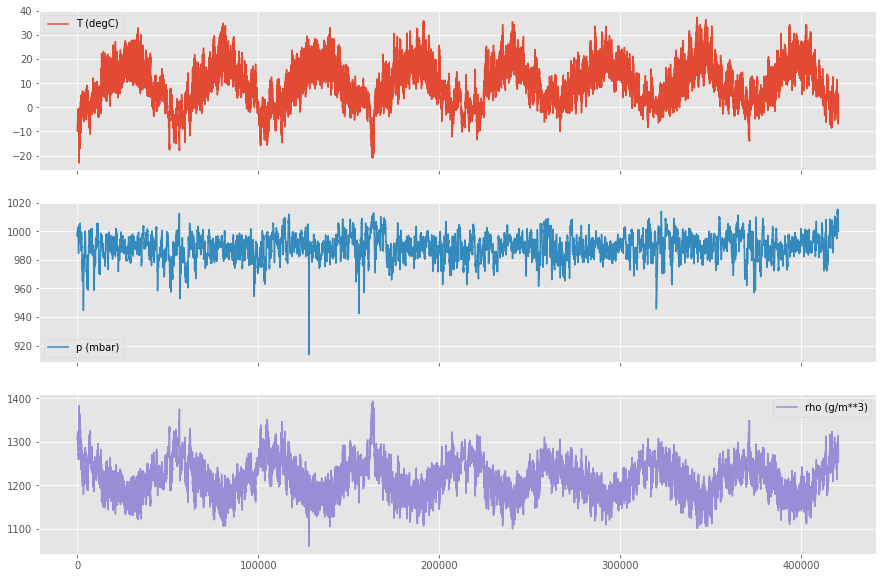

In [10]:
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (15, 10)
plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
plot_features = df_evo[plot_cols]
plot_features.plot(subplots=True, )

Se aprecian comportamientos ciclicos en las variables temperatura T (degC) y densidad del aire rho (g/m**3); en el caso de la variable presión p (mbar) se aprecia un comportamiento menos ciclico, lo cual la hace una variable interesante también para su validación. Se realiza un resamplig de la data para tener información horaria y no cada 10 minutos, esto debido a que los cambios en las condiciones climáticas suelen analizarse en periodos horarios o de mayor amplitud para evitar ruidos que pueden darse en intervalos más pequeños 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70091 entries, 5 to 420545
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date Time     70091 non-null  datetime64[ns]
 1   p (mbar)      70091 non-null  float64       
 2   T (degC)      70091 non-null  float64       
 3   rho (g/m**3)  70091 non-null  float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 2.1 MB
None
             Date Time  p (mbar)  T (degC)  rho (g/m**3)
5  2009-01-01 01:00:00    996.50     -8.05       1307.86
11 2009-01-01 02:00:00    996.62     -8.88       1312.25
17 2009-01-01 03:00:00    996.84     -8.81       1312.18
23 2009-01-01 04:00:00    996.99     -9.05       1313.61
29 2009-01-01 05:00:00    997.46     -9.63       1317.19


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f7971161a60>,
      dtype=object)

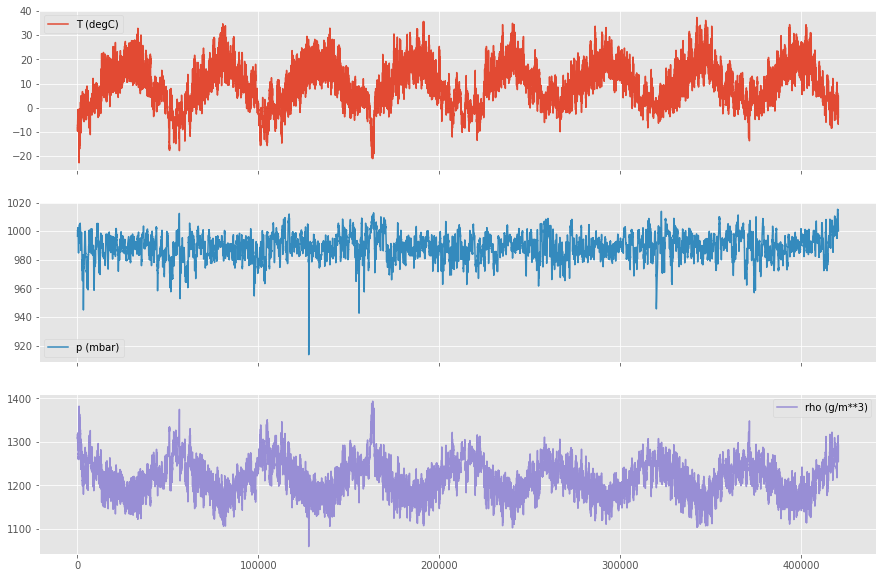

In [11]:
# Remuestreo de los datos con intervalos de 60 minutos
df_evo2 = df_evo[5::6]
print(df_evo2.info())
print(df_evo2.head(5))

# Gráficas
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (15, 10)
plot_cols = ['T (degC)', 'p (mbar)','rho (g/m**3)']
plot_features = df_evo2[plot_cols]
plot_features.plot(subplots=True)

In [12]:
df_evo3 = df_evo2.copy()

# 3.  Aplicación del model naive y red neuronal multicapa

Como método de comparación, previo al desarrollo del algoritmo genético se propone el uso de una red neuronal para la predicción de las series de tiempo en el intervalo definido. Parte de la implementación que se encuentra a continuación se basa en el desarrollo de análisis de seires de tiempo con TensorFlow hallado en https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/structured_data/time_series.ipynb#scrollTo=pa49bUnKyRgF&uniqifier=1 

El codigo del apartado a continacion presentado es una adptacion al set de datos seleccionado y corresponde solamente al punto de comparacion para el algoritmo evolutivo a desarrollar

In [16]:
date_time = pd.to_datetime(df_evo3.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')
df_evo3.head()

,p (mbar),T (degC),rho (g/m**3)
5,996.50,-8.05,1307.86
11,996.62,-8.88,1312.25
17,996.84,-8.81,1312.18
23,996.99,-9.05,1313.61
29,997.46,-9.63,1317.19


Se propone una particion de la forma:



*   70% para entrenamiento
*   20% para validacion 
*   10% para testeo

En el analisis de series de tiempo la data no es partida de manera aleatore, esto debido a que se debe garantizar que



1.   Se debe garantizar que la data mantenga su secuencia de temporalidad
2.   Se garantiza que la validacion y el testeo consideren datos posteriores a los utilizados para el entrenamiento





In [17]:
# Definición de particiones para testeo y validación

column_indices = {name: i for i, name in enumerate(df_evo3.columns)}

n = len(df_evo3)
train_df = df_evo3[0:int(n*0.7)] # entrenar con el primer 70% de los datos 
val_df = df_evo3[int(n*0.7):int(n*0.9)] # validar con el primer 20% posterior de los datos 
test_df = df_evo3[int(n*0.9):] # testear con el último 10% de los datos 

num_features = df_evo3.shape[1]

In [18]:
# Estandarización de los valores; todos los datasets se estandarizarán con la media y desviación estandar del set más grande (el set de entrenamiento)

train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [19]:
print(train_df.head(5))

    p (mbar)  T (degC)  rho (g/m**3)
5   0.945308 -1.982473      2.218524
11  0.959770 -2.078372      2.325708
17  0.986284 -2.070284      2.323998
23  1.004362 -2.098014      2.358913
29  1.061006 -2.165028      2.446320


Se definen a continuacion las siguientes funciones para la generacion de ventanas de tiempo (datos historicos)  que alimentaran la prediccion

In [20]:
# Esta funciona genera la ventana usada para la prediccion

class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [21]:
# Ventana de prueba 1 con una longitud de 3 puntos de tiempo previos a la prediccion

w1 = WindowGenerator(input_width=3, label_width=1, shift=1, label_columns=['T (degC)'])
w1

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['T (degC)']

In [22]:
# Ventana de prueba 2 con una longitud de 24 puntos de tiempo previos a la prediccion

w2 = WindowGenerator(input_width=24, label_width=1, shift=1, label_columns=['T (degC)'])
w2

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24]
Label column name(s): ['T (degC)']

Además se crea una función para realiza la partición de la ventana en una ventana de entrada (cantidad de datos utilizados par la prediccion) y una ventana de salida (label o salida que se espera producir con el modelo)

## Ejemplo de generacion de ventanas con la temperatura

In [23]:
single_step_window = WindowGenerator(input_width=1, label_width=1, shift=1, label_columns=['T (degC)'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['T (degC)']

In [24]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack([labels[:, :, self.column_indices[name]] for name in self.label_columns], axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [25]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 25, 3)
Inputs shape: (3, 24, 3)
Labels shape: (3, 1, 1)


Se genera el siguiente codigo para la visualizacion de la ventana de prediccion de temperatura

In [26]:
def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

Creacion del tf.data.Dataset. Con estas lineas se toma la serie de tiempo de entrada y se convierte en las parejas (input_window, label_window) utilizando keras

In [27]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

A contiuacion se generan propiedades para aceder a los splits de training, validation y testing

In [28]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

# Modelos base temperatura

Se propone un modelo base o baseline, este modelo simplemente entrega como prediccion del tiempo $t+1$ los datos del tiempo $t$. Esta es también conocida como la predicción naive o ingenua

In [29]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

## Baseline temperatura

Instantiate and evaluate this model:

In [30]:
baseline = Baseline(label_index=column_indices['T (degC)'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

439/439 [==============================] - 2s 4ms/step - loss: 0.0128 - mean_absolute_error: 0.0785


In [31]:
wide_window = WindowGenerator(input_width=24, label_width=24, shift=1, label_columns=['T (degC)'])
wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['T (degC)']

In [32]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 3)
Output shape: (32, 24, 1)


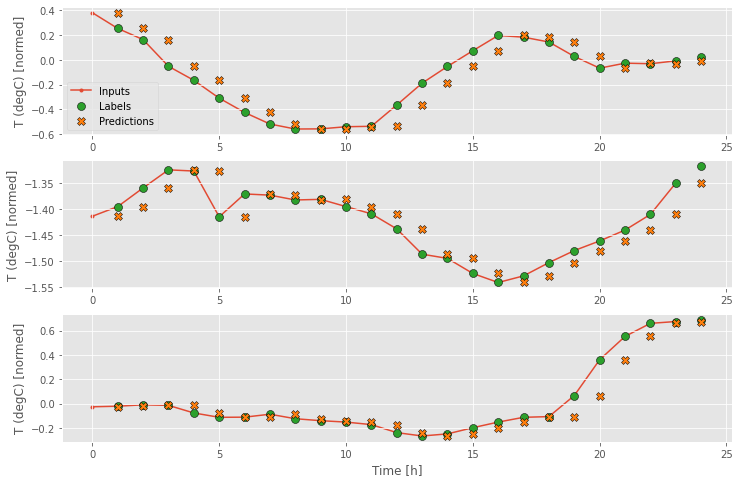

In [33]:
wide_window.plot(baseline)

## Aplicacion de un modelo multietapa-denso a temperatura

Como punto de comparacion se propone la implementacion de un modelo multietapa-denso de la siguiente manera:

In [34]:
# Primero se define la ventana de datos a utilizar como entrada al modelo

CONV_WIDTH = 24 
conv_window = WindowGenerator(input_width=CONV_WIDTH, label_width=1, shift=1,  label_columns=['T (degC)'])
conv_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24]
Label column name(s): ['T (degC)']

Text(0.5, 1.0, 'Realizar la predicción del las variables en función de las últimas 24 horas de datos')

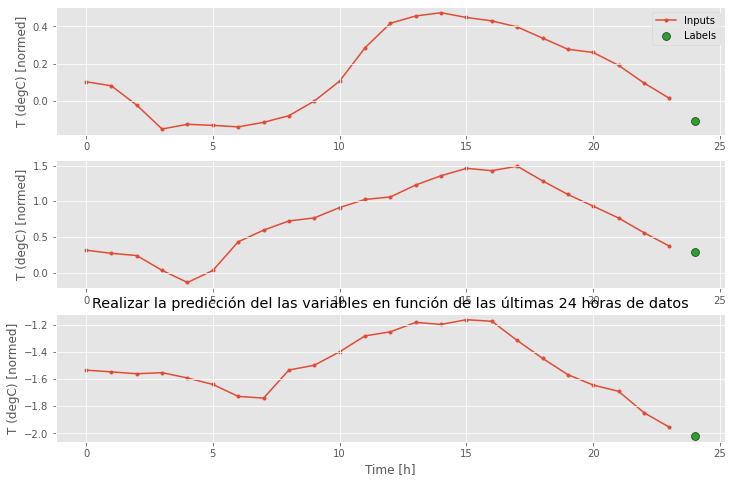

In [35]:
conv_window.plot()
plt.title("Realizar la predicción del las variables en función de las últimas 24 horas de datos")

In [36]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=3, activation='relu'),
    tf.keras.layers.Dense(units=5, activation='relu'),
    tf.keras.layers.Dense(units=3),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),])

In [37]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 24, 3)
Output shape: (32, 1, 3)


In [38]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [39]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

438/438 [==============================] - 2s 4ms/step - loss: 0.0087 - mean_absolute_error: 0.0664


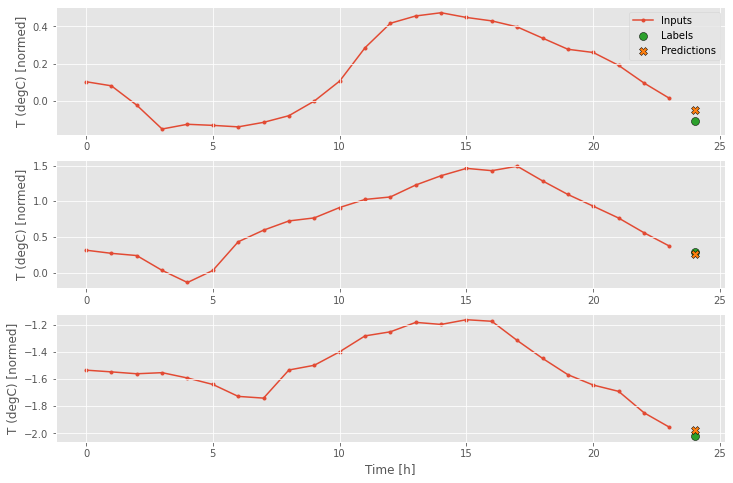

In [40]:
conv_window.plot(multi_step_dense)

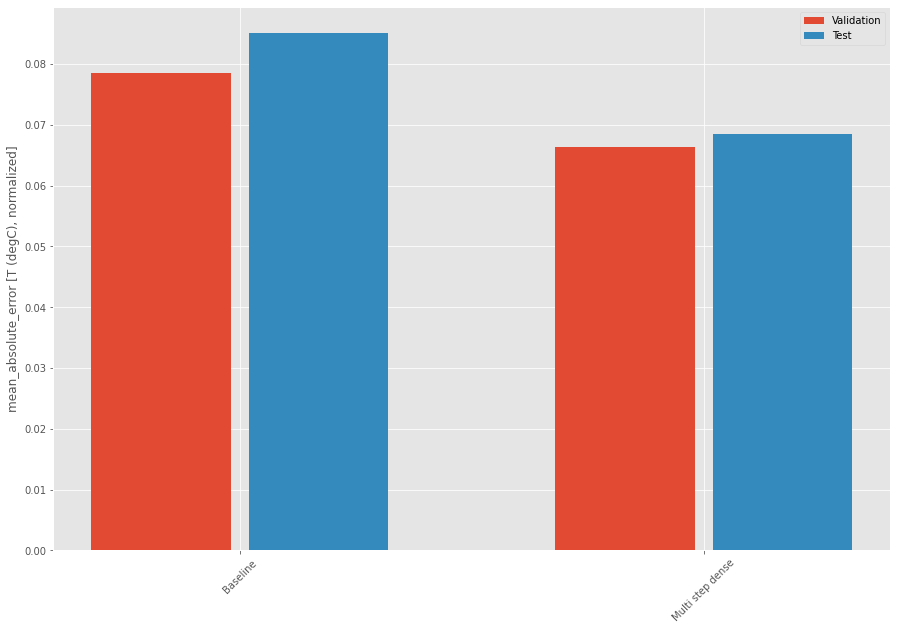

In [41]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = multi_step_dense.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [42]:
print(val_mae)
print(test_mae)

[0.07846629619598389, 0.06638696789741516]
[0.08516015112400055, 0.06842636317014694]


In [43]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 0.0852
Multi step dense: 0.0684


# Modelo base presion

In [44]:
def plot(self, model=None, plot_col='p (mbar)', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

Se propone un modelo base o baseline, este modelo simplemente entrega como prediccion del tiempo $t+1$ los datos del tiempo $t$

In [45]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

## Baseline presion

Instantiate and evaluate this model:

In [46]:
baseline = Baseline(label_index=column_indices['p (mbar)'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

439/439 [==============================] - 2s 4ms/step - loss: 1.9501 - mean_absolute_error: 1.1447


In [47]:
wide_window = WindowGenerator(input_width=24, label_width=24, shift=1, label_columns=['p (mbar)'])
wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['p (mbar)']

In [48]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 3)
Output shape: (32, 24, 1)


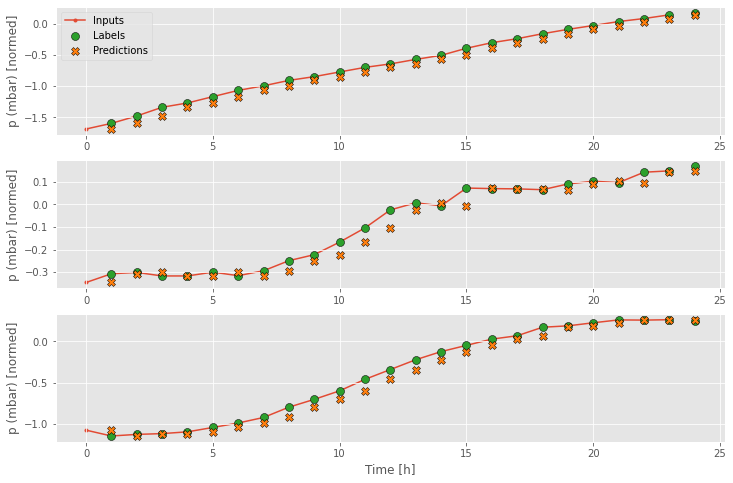

In [49]:
wide_window.plot(baseline)

## Aplicacion de un modelo multietapa-denso a la presion

Como punto de comparacion se propone la implementacion de un modelo multietapa-denso de la siguiente manera:

In [50]:
# Primero se define la ventana de datos a utilizar como entrada al modelo

CONV_WIDTH = 24 
conv_window = WindowGenerator(input_width=CONV_WIDTH, label_width=1, shift=1,  label_columns=['p (mbar)'])
conv_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24]
Label column name(s): ['p (mbar)']

Text(0.5, 1.0, 'Realizar la predicción del las variables en función de las últimas 24 horas de datos')

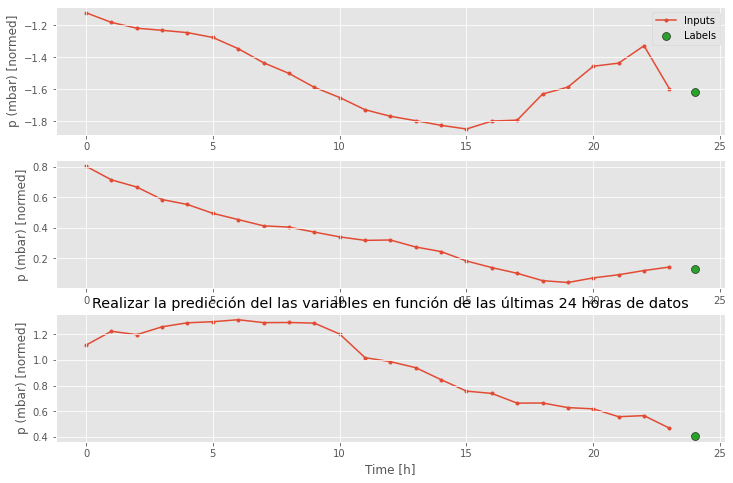

In [51]:
conv_window.plot()
plt.title("Realizar la predicción del las variables en función de las últimas 24 horas de datos")

In [52]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=3, activation='relu'),
    tf.keras.layers.Dense(units=5, activation='relu'),
    tf.keras.layers.Dense(units=3),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),])

In [53]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 24, 3)
Output shape: (32, 1, 3)


In [54]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [55]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

438/438 [==============================] - 2s 4ms/step - loss: 0.0022 - mean_absolute_error: 0.0330


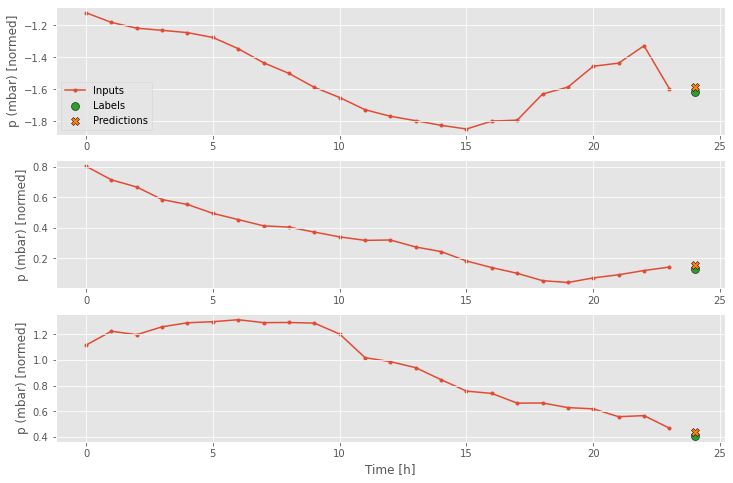

In [56]:
conv_window.plot(multi_step_dense)

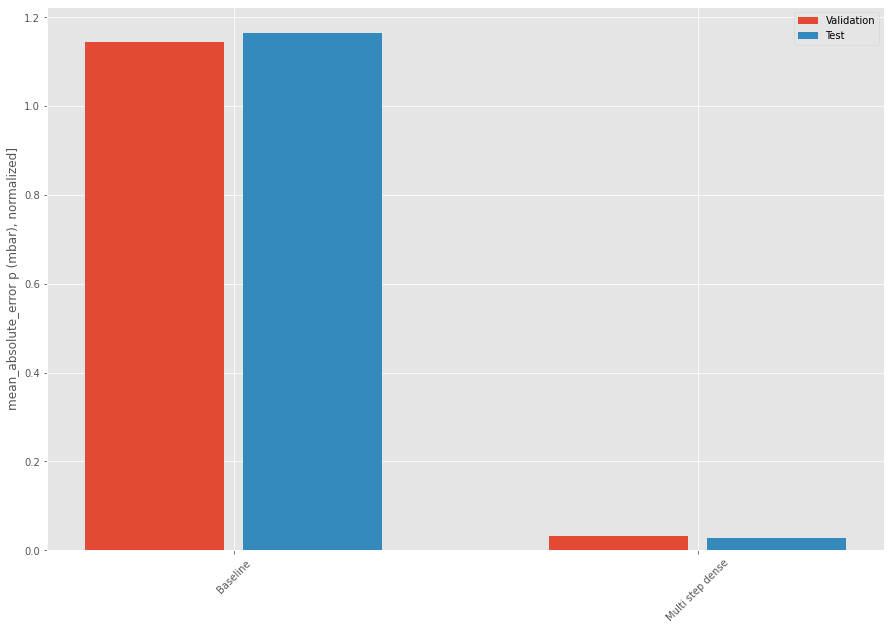

In [57]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = multi_step_dense.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error p (mbar), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [58]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 1.1652
Multi step dense: 0.0273


# Modelo base densidad del aire

In [59]:
def plot(self, model=None, plot_col='rho (g/m**3)', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

Se propone un modelo base o baseline, este modelo simplemente entrega como prediccion del tiempo $t+1$ los datos del tiempo $t$

In [60]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

## Baseline densidad del aire

Instantiate and evaluate this model:

In [61]:
baseline = Baseline(label_index=column_indices['rho (g/m**3)'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

439/439 [==============================] - 2s 4ms/step - loss: 3.0527 - mean_absolute_error: 1.4318


In [62]:
wide_window = WindowGenerator(input_width=24, label_width=24, shift=1, label_columns=['rho (g/m**3)'])
wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['rho (g/m**3)']

In [63]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 3)
Output shape: (32, 24, 1)


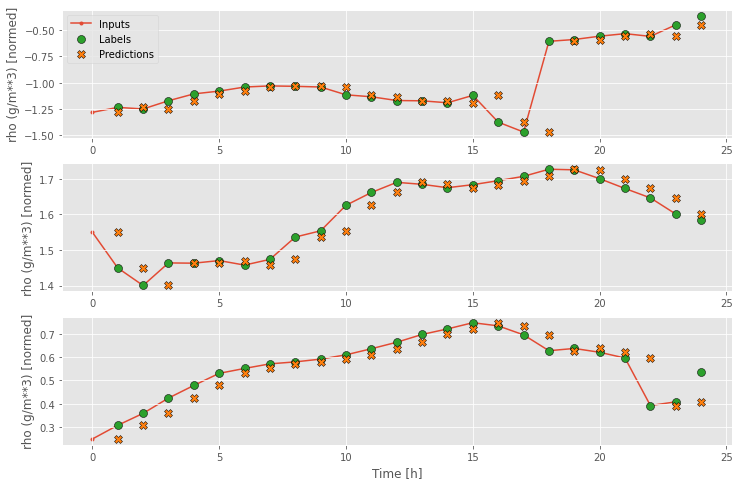

In [64]:
wide_window.plot(baseline)

## Aplicacion de un modelo multietapa-denso a la densidad del aire

Como punto de comparacion se propone la implementacion de un modelo multietapa-denso de la siguiente manera:

In [65]:
# Primero se define la ventana de datos a utilizar como entrada al modelo

CONV_WIDTH = 24 
conv_window = WindowGenerator(input_width=CONV_WIDTH, label_width=1, shift=1,  label_columns=['rho (g/m**3)'])
conv_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24]
Label column name(s): ['rho (g/m**3)']

Text(0.5, 1.0, 'Realizar la predicción del las variables en función de las últimas 24 horas de datos')

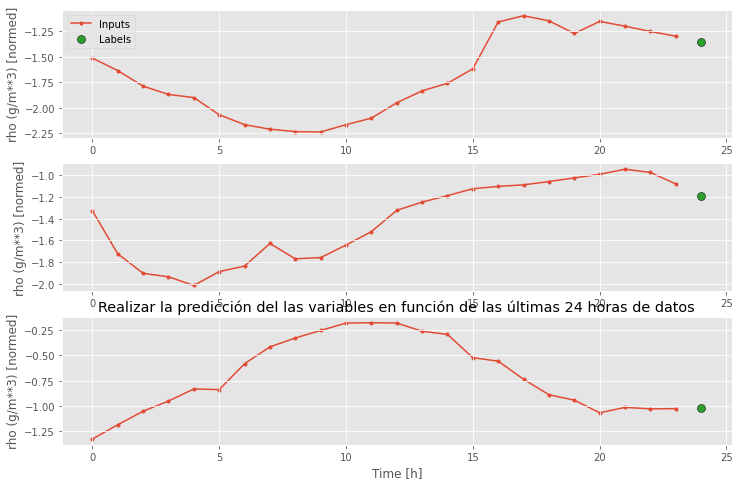

In [66]:
conv_window.plot()
plt.title("Realizar la predicción del las variables en función de las últimas 24 horas de datos")

In [67]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=3, activation='relu'),
    tf.keras.layers.Dense(units=5, activation='relu'),
    tf.keras.layers.Dense(units=3),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),])

In [68]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 24, 3)
Output shape: (32, 1, 3)


In [69]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [70]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

438/438 [==============================] - 2s 4ms/step - loss: 0.0070 - mean_absolute_error: 0.0584


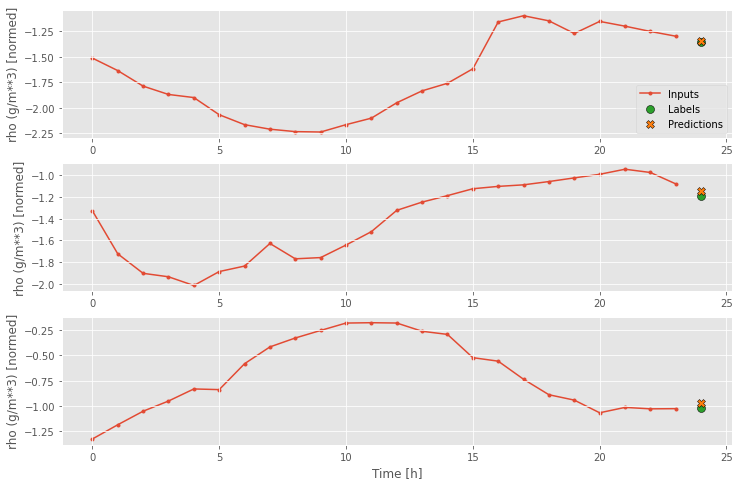

In [71]:
conv_window.plot(multi_step_dense)

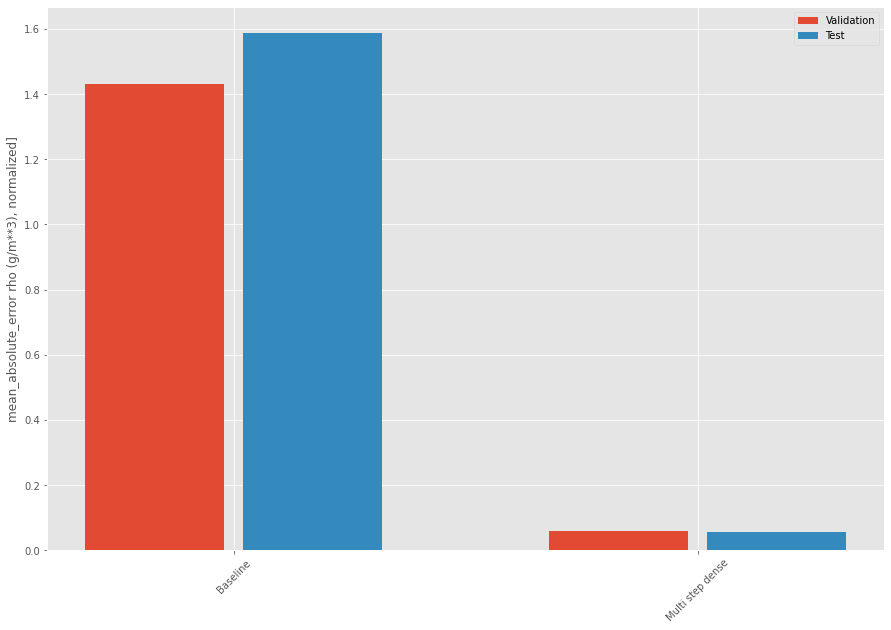

In [72]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = multi_step_dense.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error rho (g/m**3), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [73]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 1.5885
Multi step dense: 0.0575


#4. Generacion algoritmo evolutivo

La propuesta de desarrollo de un algoritmo evolutivo se encuentra basada en la documentacion https://towardsdatascience.com/unit-3-application-evolving-neural-network-for-time-series-analysis-63c057cb1595 
Se plantea el desarrollo de un algoritmo evoultivo apra la generacion de redes neuronales que permita la prediccion (paso a paso) de las variables del clima.

A continuación se encuntran las distintas partes del algoritmo encargadas de:



*   Inicialización aleatoria de individuos (matrices de pesos y bias).
*   Pareamiento y generación de nuevos individuos.
*   Mutación de individuos.
*   Generación de nuevas generaciones con individuos mas aptos en generación previa
*   Realización del algoritmo de manera iterativa hasta punto de parada definido



In [74]:
# se utilizará como función de activación la función ReLU
def relu(x):
    return np.maximum(x, 0)


class EvolvableNetwork:
    
    # La estructura propuesta para el modelo considerará una estructura con tres capas ocultas 3-5-3
    # Para la inicializaciónd de la red y su primera generación se genera una matriz de pesos y bias ("sesgos") con valores aleatorios normalmente distribuidos entre -1 y 1

    def __init__(self, layer_nodes, num_input, num_output, initialize=True):
        self.layer_count = len(layer_nodes)
        self.layer_nodes = layer_nodes
        self.num_input = num_input
        self.num_output = num_output
        self.activation_function = relu 

        self.layer_weights = []
        self.layer_biases = []

        if not initialize:  
            return
        
        # creación de matriz de pesos y bias en capa de entrada
        self.layer_weights.append(
            np.random.uniform(-1, 1, num_input * layer_nodes[0]).reshape(num_input, layer_nodes[0]))
        self.layer_biases.append(np.random.uniform(-1, 1, layer_nodes[0]))
        
        # creación de pesos y bias en capas ocultas
        for i in range(1, self.layer_count):
            self.layer_weights.append(
                np.random.uniform(-1, 1, layer_nodes[i-1]*layer_nodes[i]).reshape(layer_nodes[i-1], layer_nodes[i]))
            self.layer_biases.append(np.random.uniform(-1, 1, layer_nodes[i]).reshape(1, layer_nodes[i]))
        
        # creación de pesos y bias en la capa de salida
        self.layer_weights.append(
            np.random.uniform(-1, 1, layer_nodes[self.layer_count-1]*num_output).reshape(layer_nodes[self.layer_count-1],
                                                                                         num_output))
        self.layer_biases.append(np.random.uniform(-1, 1, num_output).reshape(1, num_output))
  
    # Multiplicación de las matrices, clase creada para el calculo de la salida (y) con las matrices previamente definidas

    def predict(self, x):  
        output = self.activation_function(np.dot(x, self.layer_weights[0]) + self.layer_biases[0])
        for i in range(1, self.layer_count + 1):
            if i == self.layer_count:  
                output = (np.dot(output, self.layer_weights[i]) + self.layer_biases[i])
            else:
                output = self.activation_function(
                    np.dot(output, self.layer_weights[i]) + self.layer_biases[i])
        if self.num_output == 1:  
            return output.reshape(len(x), )
        return output

In [75]:
# Los autores proponene como método de selección el uso de la selección por ruleta rusa eligiendo que porcentaje del individuo será utilizada según su función de "fitness" o ajuste

def roulette_wheel_selection(cumulative_sum, n):
    ind = []
    r = np.random.uniform(0, 1, n)
    for i in range(0, n):
        index = 0
        while cumulative_sum[index] < r[i]:
            index += 1
        ind.append(index)
    return ind

In [76]:
# Las redes p1 y p2 serán considerados los padres en cada cruce, se realiza entonces un cruce lineal entre estos dos con un rango entre [0 y 1]

def crossover(p1, p2, const_cross):
    # Se inicializan los hijos con una matríz vacia
    child = EvolvableNetwork(layer_nodes=p1.layer_nodes, num_input=p1.num_input, num_output=p1.num_output,
                             initialize=False)
    # Los Los hijos son entonces el resultado de la combinación lineal previamente definida
    for i in range(0, p1.layer_count+1):
        child.layer_weights.append( (1-const_cross)*p1.layer_weights[i]+const_cross*p2.layer_weights[i])
        child.layer_biases.append( (1-const_cross)*p1.layer_biases[i]+const_cross*p2.layer_biases[i])

    return child

In [77]:
# Se define una cosntante de mutación
def mutation(child, const_mutate):
    # Aplicar constante en todas las capas
    for i in range(0, child.layer_count+1):
        n, c = child.layer_weights[i].shape        
        r_w = np.random.uniform(-const_mutate, const_mutate, n*c)
      
        for nr in range(0, n):
            for nc in range(0, c):
                child.layer_weights[i][nr, nc] += r_w[nr*c+nc]
                
    # Aplicar constante en todas las capas
    for i in range(0, child.layer_count+1):
        c = child.layer_biases[i].shape[0]
        r_w = np.random.uniform(-const_mutate, const_mutate, c)
        for nc in range(0, c):
            child.layer_biases[i][nc] += r_w[nc]

In [78]:
# p1 and p2 son los padres (matrices)
def reproduce(p1, p2, const_mutate, fitness_function, data):
    # Se crea un valor diferente de cruce para cada uno de los hijos
    c_cross = np.random.normal(0.5, 0.15, 4)
    ch1 = crossover(p1, p2, c_cross[0])
    ch2 = crossover(p1, p2, c_cross[1])
    ch3 = crossover(p1, p2, c_cross[2])
    ch4 = crossover(p1, p2, c_cross[3])
    # Se propone realizar mutación de los hijos 3 y 4
    mutation(ch3, const_mutate)
    mutation(ch4, const_mutate)
    # Finalmente se juntan todos los individuos (padres e hijos) y se selecciona al individuo con el mejor Fitness.
    all = [p1, p2, ch1, ch2, ch3, ch4]
    fit = fitness_function(all, data) 
    return all[np.argmin(fit)]

Funcion de fitness: MSE

Está será la métrica de comparación entre los distintos individuos.

In [79]:
from sklearn.metrics import mean_squared_error
def fitness_function(models, data):
    mse_values = []
    x = data[0]
    y = data[1]
    for network in models:
        predictions = network.predict(x)
        mse = mean_squared_error(y, predictions)
        mse_values.append(mse)
    return np.asarray(mse_values)

In [80]:
def scale_fitness(x):
    return 1 / (1 + x)

# Split del dataset y pruebas


In [81]:
def evolve(init_gen, const_mutate, max_iter, train_data, val_data):
    gen = init_gen
    mean_fitness = []
    val_mean = []  
    best_fitness = []
    prev_val = 1000
    n = len(gen)
    val_index = 0
    for k in range(0, max_iter):
        fitness = fitness_function(gen, train_data)
        scaled_fit = scale_fitness(fitness)

        # Creación de la distribución para la selección de insividuos a reproducir
        fit_sum = np.sum(scaled_fit)
        fit = scaled_fit / fit_sum
        cumulative_sum = np.cumsum(fit)

        selected = roulette_wheel_selection(cumulative_sum, n)
        mates = roulette_wheel_selection(cumulative_sum, n)

        children = []
        for i in range(0, n):
            children.append(reproduce(gen[selected[i]], gen[mates[i]], const_mutate, fitness_function, train_data))

        gen_next = children

        # Evaluación en el Dataset de entrenamiento
        fit = fitness_function(gen_next, train_data)
        fit_mean = np.mean(fit)
        fit_best = np.min(fit)
        mean_fitness.append(fit_mean)
        best_fitness.append(fit_best)

        # Evaluación en el Dataset de evalidación
        val_fit = fitness_function(gen_next, val_data)
        val_fit_mean = np.mean(val_fit)
        val_mean.append(val_fit_mean)

        print("Generation: " + str(k))
        print(" Best: {}, Avg: {}".format(fit_best, fit_mean))
        print(" Validation: {}".format(val_fit_mean))

        gen = gen_next

        # Validación de que las generaciones vayan teniendo un incremento en el fitness frente a sus predecesoras
        if val_fit_mean > prev_val:
            val_index += 1
        else:
            val_index = 0
        if val_index == 3:  # Dfinición de umbral de overfitting para detener el algoritmo
            print("Over Fitting, Stopping...")
            break
        prev_val = val_fit_mean

    # Se utilizan los resultados de la data de validación para la selección del mejor individuo
    val_fit = fitness_function(gen_next, val_data)
    best_val = np.min(val_fit)
    best_ind = np.argmin(val_fit)
    print("Best Model: ")
    print(" Validation: {}".format(best_val))
    return gen_next[best_ind]

Finalmente, al igual que en la aproximación realizada por redes neuronales se realiza la normalización de las columnas seleccionadas del dataset:

In [82]:
df_evo3 = (df_evo3-df_evo3.mean())/df_evo3.std()
df_evo3.head()

,p (mbar),T (degC),rho (g/m**3)
5,0.871786,-2.077607,2.296447
11,0.886142,-2.176142,2.406267
17,0.912461,-2.167832,2.404516
23,0.930406,-2.196324,2.440289
29,0.986634,-2.265180,2.529847


## Aplicación del modelo evolutivo para para la temperatura

In [83]:
y = np.asarray(df_evo3['T (degC)'])
size = len(y)
# 70% de los datos para entrenamiento
train_ind = int(size * 0.7)
# 20% de los datos para validación y 10% de los datos para testeo
val_ind = int(size * 0.9)

max_window = 24
min_window = 23
initial_population_size = 100 # 100 redes iniciales
best_models = []  
best_fits = []
# aleatorización de indices para los cruces
shuffled_indices = np.asarray(range(0, size-max_window))
np.random.shuffle(shuffled_indices)
# El algoritmo original incorporaba la prueba de distintas ventanas (cantidad de datos a considerar como input), para nuestro caso mantendremos este valor constante en un valor de 24 datos (un día)
for vision in range(min_window, max_window + 1):
    input = []
    output = []
    for j in range(vision, size):
        input.append(y[(j - vision):j].tolist())
        output.append(y[j])

    input = np.asarray(input)
    output = np.asarray(output)

    temp = np.column_stack((output, input))

    temp = temp[shuffled_indices]

    output = temp[:, 0]
    input = temp[:, 1:]

    y_train = output[0:train_ind]
    y_val = output[train_ind:val_ind]
    y_test = output[val_ind:size]
    x_train = input[0:train_ind]
    x_val = input[train_ind:val_ind]
    x_test = input[val_ind:size]

    init_gen = []
    for i in range(0, initial_population_size):
        init_gen.append(EvolvableNetwork(layer_nodes=[3, 5, 3], num_input=vision, num_output=1, initialize=True)) 

    best_model = evolve(init_gen, const_mutate=0.1, max_iter=20, train_data=[x_train, y_train], val_data=[x_val, y_val])
    best_models.append(best_model)
    best_fits.append(fitness_function([best_model], [x_val, y_val]))

Generation: 0
 Best: 0.3363446024686779, Avg: 0.9536170871776473
 Validation: 0.9551165902375565
Generation: 1
 Best: 0.3363446024686779, Avg: 0.715677805257679
 Validation: 0.7148243499270567
Generation: 2
 Best: 0.3363446024686779, Avg: 0.5680631562031916
 Validation: 0.5656334276936225
Generation: 3
 Best: 0.26766749604685275, Avg: 0.45786619200171985
 Validation: 0.4554629908297035
Generation: 4
 Best: 0.21543059481162855, Avg: 0.38739461891494825
 Validation: 0.38588437416153804
Generation: 5
 Best: 0.2009389799982408, Avg: 0.33003712414210296
 Validation: 0.33062794542370016
Generation: 6
 Best: 0.1755449185891887, Avg: 0.28177423212972974
 Validation: 0.2837484489944283
Generation: 7
 Best: 0.1626803839299134, Avg: 0.2294126448702359
 Validation: 0.23220391424097261
Generation: 8
 Best: 0.16260980443663942, Avg: 0.19873762670326198
 Validation: 0.20190178767757383
Generation: 9
 Best: 0.16135106532939236, Avg: 0.18222005930239138
 Validation: 0.18555775829727023
Generation: 10
 


Best Validation Fitness Values Per Window Size:
Window Size: 23 - Validation MSE: 0.12433823385538459
Window Size: 24 - Validation MSE: 0.12319674889321776
Best Model: 
 Window Size : 4
 MSE for Test Data Set : 0.12209978934326755


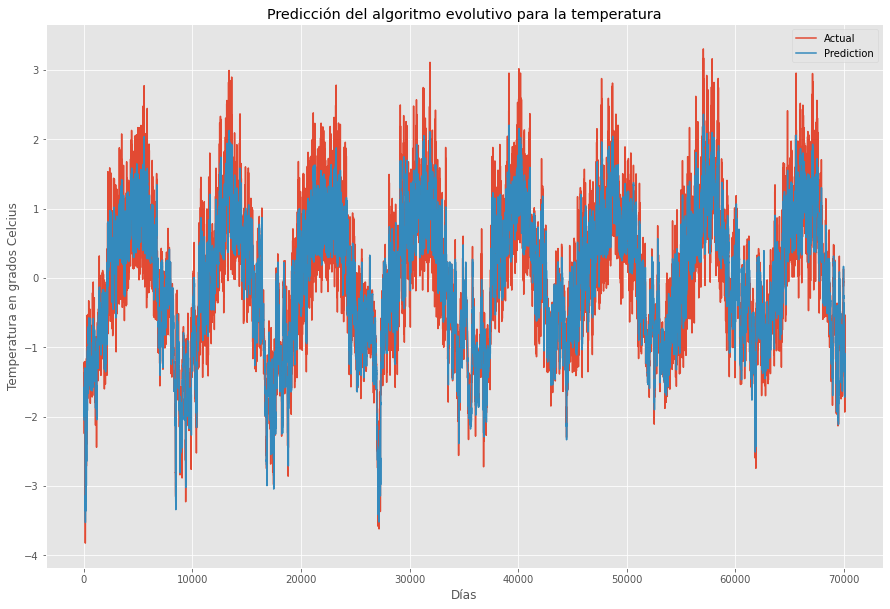

In [84]:
# Selección del mejor modelo con la función de Fitness definida
best_index = np.argmin(best_fits)
best_model = best_models[best_index]
vision = best_index + min_window
input = []
output = []
for j in range(vision, size):
    input.append(y[(j - vision):j].tolist())
    output.append(y[j])
input = np.asarray(input)
output = np.asarray(output)
temp = np.column_stack((output, input))
temp = temp[shuffled_indices]
output_2 = temp[:, 0]
input_2 = temp[:, 1:]
y_test = output_2[val_ind:size]
x_test = input_2[val_ind:size]

# Evaluación en el dataset de testeo (10% final)
mse_test = fitness_function([best_model], [x_test, y_test])
print("\nBest Validation Fitness Values Per Window Size:")
index = 0
for fit in best_fits:
    print("Window Size: {} - Validation MSE: {}".format(index+min_window, best_fits[index][0]))
    index += 1
print("Best Model: \n"
      " Window Size : {}\n"
      " MSE for Test Data Set : {}".format(best_index+3, mse_test[0]))

# Impresión de reultados 
xaxis = range(vision, len(y))
plt.plot(xaxis, y[vision:], label="Actual")
plt.plot(xaxis, best_model.predict(input), label="Prediction")
plt.xlabel("Días")
plt.ylabel("Temperatura en grados Celcius")
plt.title("Predicción del algoritmo evolutivo para la temperatura")
plt.legend()
plt.show()

## Aplicación del modelo evolutivo para para la presión

In [85]:
y = np.asarray(df_evo3['p (mbar)'])
size = len(y)
# 70% de los datos para entrenamiento
train_ind = int(size * 0.7)
# 20% de los datos para validación y 10% de los datos para testeo
val_ind = int(size * 0.9)

max_window = 24
min_window = 23
initial_population_size = 100 # 100 redes iniciales
best_models = []  
best_fits = []
# aleatorización de indices para los cruces
shuffled_indices = np.asarray(range(0, size-max_window))
np.random.shuffle(shuffled_indices)
# El algoritmo original incorporaba la prueba de distintas ventanas (cantidad de datos a considerar como input), para nuestro caso mantendremos este valor constante en un valor de 24 datos (un día)
for vision in range(min_window, max_window + 1):
    input = []
    output = []
    for j in range(vision, size):
        input.append(y[(j - vision):j].tolist())
        output.append(y[j])

    input = np.asarray(input)
    output = np.asarray(output)

    temp = np.column_stack((output, input))

    temp = temp[shuffled_indices]

    output = temp[:, 0]
    input = temp[:, 1:]

    y_train = output[0:train_ind]
    y_val = output[train_ind:val_ind]
    y_test = output[val_ind:size]
    x_train = input[0:train_ind]
    x_val = input[train_ind:val_ind]
    x_test = input[val_ind:size]

    init_gen = []
    for i in range(0, initial_population_size):
        init_gen.append(EvolvableNetwork(layer_nodes=[3, 5, 3], num_input=vision, num_output=1, initialize=True)) 

    best_model = evolve(init_gen, const_mutate=0.1, max_iter=20, train_data=[x_train, y_train], val_data=[x_val, y_val])
    best_models.append(best_model)
    best_fits.append(fitness_function([best_model], [x_val, y_val]))

Generation: 0
 Best: 0.29637761077630875, Avg: 0.9094079081443698
 Validation: 0.9256667710611259
Generation: 1
 Best: 0.29637761077630875, Avg: 0.620281711155265
 Validation: 0.6330945865245947
Generation: 2
 Best: 0.273881693920049, Avg: 0.44347161747897634
 Validation: 0.45180735192532573
Generation: 3
 Best: 0.273881693920049, Avg: 0.36883898997000775
 Validation: 0.37677494996867744
Generation: 4
 Best: 0.2466302625820878, Avg: 0.32801650947098
 Validation: 0.33598414696333767
Generation: 5
 Best: 0.18800460435124308, Avg: 0.29045713049701194
 Validation: 0.3038379253143571
Generation: 6
 Best: 0.18800460435124308, Avg: 0.26594466174669884
 Validation: 0.28182207240050894
Generation: 7
 Best: 0.17413610585662345, Avg: 0.24461679456344892
 Validation: 0.26105838795911723
Generation: 8
 Best: 0.1472683867004734, Avg: 0.21898423212246143
 Validation: 0.2353164703350521
Generation: 9
 Best: 0.1458376478655838, Avg: 0.19930142999148737
 Validation: 0.21582102983614923
Generation: 10
 B


Best Validation Fitness Values Per Window Size:
Window Size: 23 - Validation MSE: 0.09183830360765827
Window Size: 24 - Validation MSE: 0.1023233049423252
Best Model: 
 Window Size : 3
 MSE for Test Data Set : 0.08871101893983332


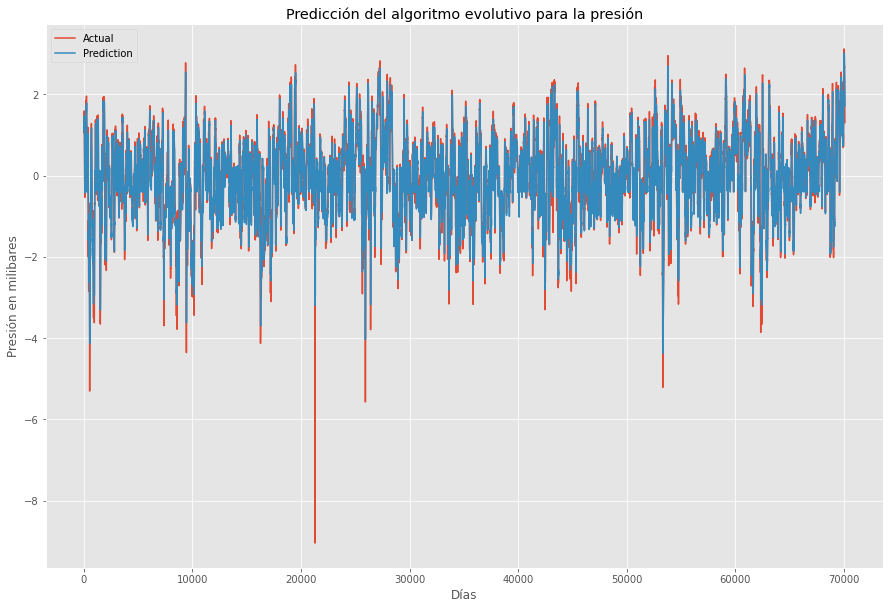

In [86]:
# Selección del mejor modelo con la función de Fitness definida
best_index = np.argmin(best_fits)
best_model = best_models[best_index]
vision = best_index + min_window
input = []
output = []
for j in range(vision, size):
    input.append(y[(j - vision):j].tolist())
    output.append(y[j])
input = np.asarray(input)
output = np.asarray(output)
temp = np.column_stack((output, input))
temp = temp[shuffled_indices]
output_2 = temp[:, 0]
input_2 = temp[:, 1:]
y_test = output_2[val_ind:size]
x_test = input_2[val_ind:size]

# Evaluación en el dataset de testeo (10% final)
mse_test = fitness_function([best_model], [x_test, y_test])
print("\nBest Validation Fitness Values Per Window Size:")
index = 0
for fit in best_fits:
    print("Window Size: {} - Validation MSE: {}".format(index+min_window, best_fits[index][0]))
    index += 1
print("Best Model: \n"
      " Window Size : {}\n"
      " MSE for Test Data Set : {}".format(best_index+3, mse_test[0]))

# Impresión de reultados 
xaxis = range(vision, len(y))
plt.plot(xaxis, y[vision:], label="Actual")
plt.plot(xaxis, best_model.predict(input), label="Prediction")
plt.xlabel("Días")
plt.ylabel("Presión en milibares")
plt.title("Predicción del algoritmo evolutivo para la presión")
plt.legend()
plt.show()

## Aplicación del modelo evolutivo para para la densidad del aire

In [87]:
y = np.asarray(df_evo3['rho (g/m**3)'])
size = len(y)
# 70% de los datos para entrenamiento
train_ind = int(size * 0.7)
# 20% de los datos para validación y 10% de los datos para testeo
val_ind = int(size * 0.9)

max_window = 24
min_window = 23
initial_population_size = 100 # 100 redes iniciales
best_models = []  
best_fits = []
# aleatorización de indices para los cruces
shuffled_indices = np.asarray(range(0, size-max_window))
np.random.shuffle(shuffled_indices)
# El algoritmo original incorporaba la prueba de distintas ventanas (cantidad de datos a considerar como input), para nuestro caso mantendremos este valor constante en un valor de 24 datos (un día)
for vision in range(min_window, max_window + 1):
    input = []
    output = []
    for j in range(vision, size):
        input.append(y[(j - vision):j].tolist())
        output.append(y[j])

    input = np.asarray(input)
    output = np.asarray(output)

    temp = np.column_stack((output, input))

    temp = temp[shuffled_indices]

    output = temp[:, 0]
    input = temp[:, 1:]

    y_train = output[0:train_ind]
    y_val = output[train_ind:val_ind]
    y_test = output[val_ind:size]
    x_train = input[0:train_ind]
    x_val = input[train_ind:val_ind]
    x_test = input[val_ind:size]

    init_gen = []
    for i in range(0, initial_population_size):
        init_gen.append(EvolvableNetwork(layer_nodes=[3, 5, 3], num_input=vision, num_output=1, initialize=True)) 

    best_model = evolve(init_gen, const_mutate=0.1, max_iter=20, train_data=[x_train, y_train], val_data=[x_val, y_val])
    best_models.append(best_model)
    best_fits.append(fitness_function([best_model], [x_val, y_val]))

Generation: 0
 Best: 0.3339953305726513, Avg: 0.9292435290840615
 Validation: 0.9227543909438625
Generation: 1
 Best: 0.3339953305726513, Avg: 0.7266184172190979
 Validation: 0.7212283479366026
Generation: 2
 Best: 0.2885303000545854, Avg: 0.5569059815846712
 Validation: 0.5543039798784729
Generation: 3
 Best: 0.2885303000545854, Avg: 0.3984787604078639
 Validation: 0.39938021304851956
Generation: 4
 Best: 0.26885546688034095, Avg: 0.3412283958670065
 Validation: 0.3433974170865954
Generation: 5
 Best: 0.25457623713667726, Avg: 0.3081234309585948
 Validation: 0.31110198400583816
Generation: 6
 Best: 0.24995043631808728, Avg: 0.2915045410079027
 Validation: 0.2949081549490265
Generation: 7
 Best: 0.24058390671809732, Avg: 0.27861380694590704
 Validation: 0.28216955861503284
Generation: 8
 Best: 0.22488224429554685, Avg: 0.26488557090462966
 Validation: 0.2684006097247327
Generation: 9
 Best: 0.20936908600979817, Avg: 0.2529605825437304
 Validation: 0.25650985249256086
Generation: 10
 Be


Best Validation Fitness Values Per Window Size:
Window Size: 23 - Validation MSE: 0.16093197708217563
Window Size: 24 - Validation MSE: 0.2628838227913329
Best Model: 
 Window Size : 3
 MSE for Test Data Set : 0.1533485045788124


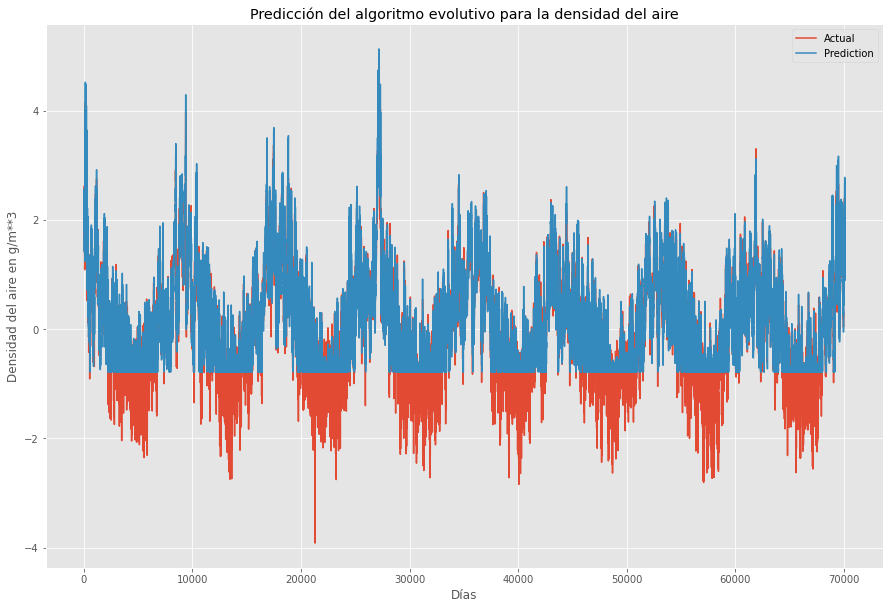

In [88]:
# Selección del mejor modelo con la función de Fitness definida
best_index = np.argmin(best_fits)
best_model = best_models[best_index]
vision = best_index + min_window
input = []
output = []
for j in range(vision, size):
    input.append(y[(j - vision):j].tolist())
    output.append(y[j])
input = np.asarray(input)
output = np.asarray(output)
temp = np.column_stack((output, input))
temp = temp[shuffled_indices]
output_2 = temp[:, 0]
input_2 = temp[:, 1:]
y_test = output_2[val_ind:size]
x_test = input_2[val_ind:size]

# Evaluación en el dataset de testeo (10% final)
mse_test = fitness_function([best_model], [x_test, y_test])
print("\nBest Validation Fitness Values Per Window Size:")
index = 0
for fit in best_fits:
    print("Window Size: {} - Validation MSE: {}".format(index+min_window, best_fits[index][0]))
    index += 1
print("Best Model: \n"
      " Window Size : {}\n"
      " MSE for Test Data Set : {}".format(best_index+3, mse_test[0]))

# Impresión de reultados 
xaxis = range(vision, len(y))
plt.plot(xaxis, y[vision:], label="Actual")
plt.plot(xaxis, best_model.predict(input), label="Prediction")
plt.xlabel("Días")
plt.ylabel("Densidad del aire en g/m**3")
plt.title("Predicción del algoritmo evolutivo para la densidad del aire")
plt.legend()
plt.show()